In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
#!conda install pytorch torchvision cuda90 -c pytorch -y
#! pip install qn
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = DisNet(config['dim_x'])
gen_net = GenNet(config['dim_z'],config['dim_x'])
dis_net.cuda()
gen_net.cuda()

dis_optim = optim.Adam(dis_net.parameters(), lr=config['dis_lr'],
    betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.Adam(gen_net.parameters(), lr=config['gen_lr'],
    betas=(config['gen_beta1'],config['gen_beta2']))

500


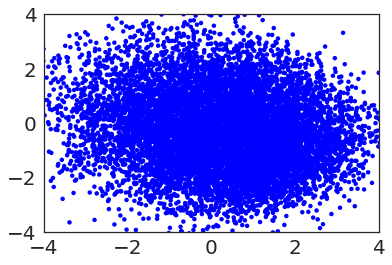

/home/ec2-user/SageMaker/gan-torch/2d-mixtures-improved/plot.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(bg_color)


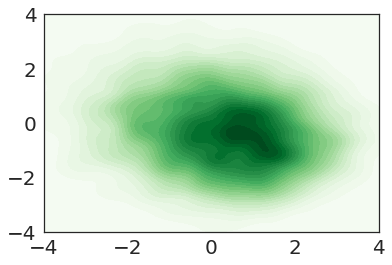

1000


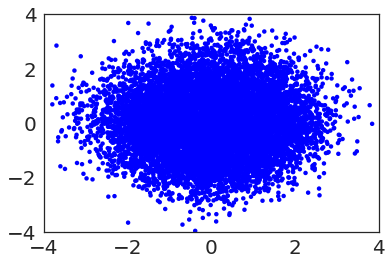

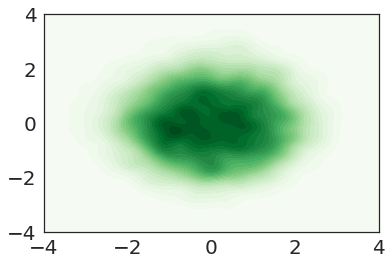

1500


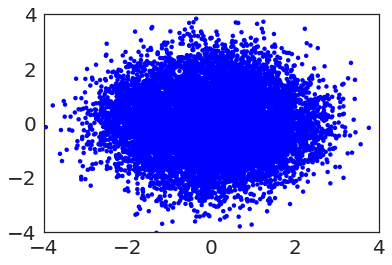

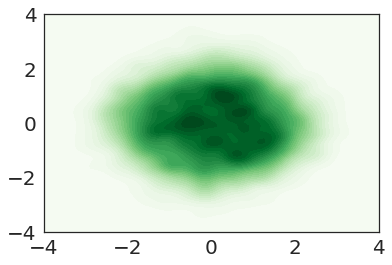

2000


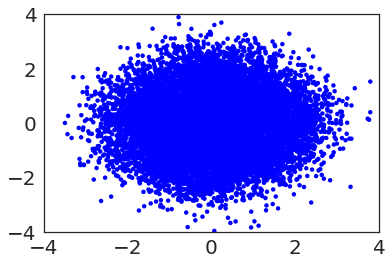

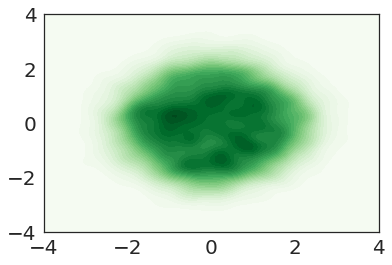

2500


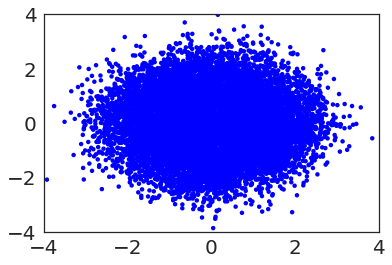

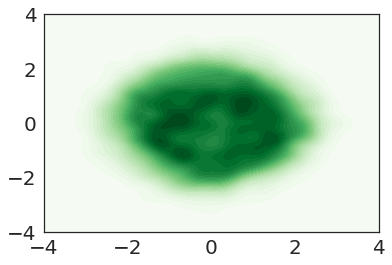

3000


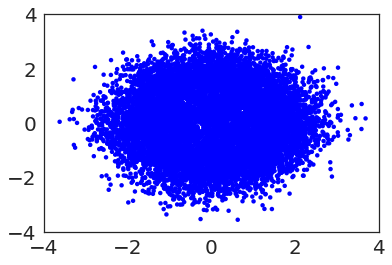

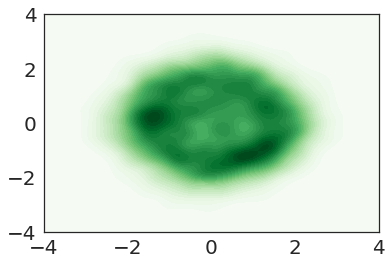

3500


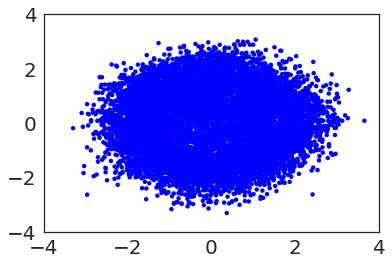

In [ ]:
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        samples_true = sampler.gaussian_mixture_circle(
            batchsize, config['num_mixture'],
            scale=config['scale'],std=config['std'])
        samples_true_numpy = samples_true / config['scale']
        samples_true = Variable(torch.from_numpy(samples_true_numpy).cuda())
        z = sampler.sample_z(config['dim_z'],batchsize,
            gaussian=config['gaussian'])
        z = Variable(torch.from_numpy(z).cuda())
        samples_fake = gen_net(z).detach()
        samples_fake /= config['scale']
        samples_fake_numpy = samples_fake.data.cpu().numpy()

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(torch.from_numpy(
            samples_mid_numpy).cuda(),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,torch.ones(f_mid.size()).cuda(),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(loss_critic.data.cpu().numpy()[0])

        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()

    prog.add_loss_dis()
    z = sampler.sample_z(config['dim_z'],batchsize,
        gaussian=config['gaussian'])
    z = Variable(torch.from_numpy(z).cuda())
    samples_fake = gen_net(z)
    samples_fake /= config['scale']
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(loss_gen.data.cpu().numpy()[0])

    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()

    if (i+1)%config['num_plot'] == 0:
        print(i+1)
        z = sampler.sample_z(config['dim_z'],10000,
            gaussian=config['gaussian'])
        z = Variable(torch.from_numpy(z).cuda())
        samples_fake = gen_net(z).data.cpu().numpy()
        plot.plot_scatter(samples_fake,filename='{}_scatter'.format(i+1),show=True)
        plot.plot_kde(samples_fake,filename='{}_kde'.format(i+1),show=True)
prog.plot()

In [ ]:
a = torch.ones(5)*3
a.cuda()
b = a*a
a.numpy()
b.numpy()
print(b)